In [8]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns 
import geopandas as gpd
import pandas as pd 
import numpy as np
import requests
import shapely
import pickle
import progressbar
import geopy.distance
from shapely.geometry import Point, Polygon, LineString 
from shapely.ops import nearest_points
from shapely.ops import transform
from shapely import geometry, ops
from functools import partial
from itertools import combinations
import geopandas as gpd
import pyproj
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.sparse import lil_matrix
import itertools
import warnings
warnings.simplefilter('ignore')
import random
from random import choice, randint
import timeit
import time
import threading
from multiprocessing import Pool
from joblib import Parallel, delayed
import functions
from functions import *
#os.chdir('C:\\Users\\piene\\Dropbox\\Python')
#os.getcwd()

In [12]:
path = "Data/B10000-CS2.gpickle"
B = nx.read_gpickle(path)
H = nx.read_gpickle("Data/H.gpickle")
df = pd.read_pickle("Data/flows.csv")
# CS_simplified = df.read_pickle("Data/CS_simplified.csv")
G = nx.read_gpickle("Data/unsimp.gpickle")
CS = pd.read_csv("Data/AllCurrentCS.csv", encoding="Cp1252")
CS = CS.drop('Unnamed: 0', axis=1)
with open('Data\AllCSnodes.pickle', 'rb') as handle:
    AllCSnodes = pickle.load(handle)
with open('Data\lengths.pickle', 'rb') as handle:
    lengths_dict = pickle.load(handle)

In [13]:
B_dict={}
for i in B.edges:
    key_t=tuple(B.edges[i]['id'])
    key_f=tuple(reversed(B.edges[i]['id']))
    len_t=B.edges[i]['eff_len_t']
    len_f=B.edges[i]['eff_len_f']
    
    B_dict[key_t]=len_t
    B_dict[key_f]=len_f

paths=df['path'].to_dict()
flows=tuple(df['flow'])

In [14]:
OD_nodes = []
for i in B.nodes:
    if B.nodes[i]['OD']==1:
        OD_nodes.append(i)
    
keys = []
vals = []
for i in OD_nodes:
    x = B.nodes[i]['x']
    y = B.nodes[i]['y']
    z = (x,y)
    keys.append(i)
    vals.append(z)
zip_iter=zip(keys,vals)
posB = dict(zip_iter)

keys = []
vals = []
for i in B.nodes:
    x = B.nodes[i]['x']
    y = B.nodes[i]['y']
    z = (x,y)
    keys.append(i)
    vals.append(z)
zip_iter=zip(keys,vals)
posAll = dict(zip_iter)

Allnodes = [i for i in B.nodes]    
Alledges = [i for i in B.edges]

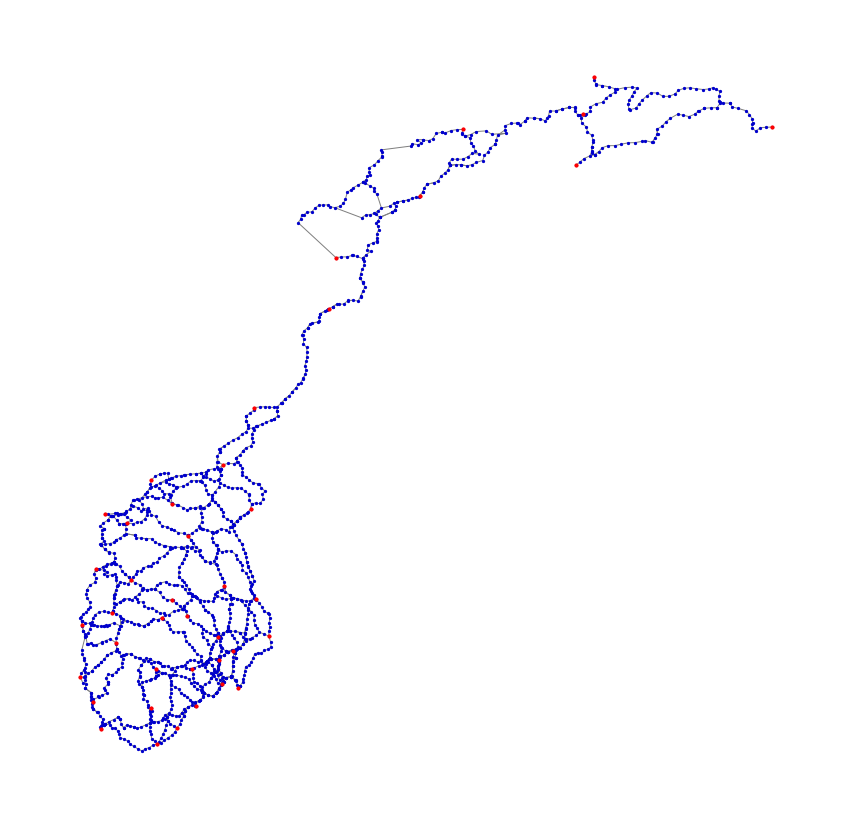

In [15]:
# %%capture
# Capture outoput because figure is very large

# Plot node elevation with colorbar legend,

cmap = plt.cm.get_cmap('bwr')

nc = ox.plot.get_node_colors_by_attr(B, 'OD', cmap=cmap, equal_size=True)

plt.figure(figsize=(15,15))
# ADD CUSTOM MINUMUM AND MAXIMUM VALUES RETRIEVED FROM THE OUTLIER DETECTOR
# norm=plt.Normalize(vmin=-151, vmax=1246)
# norm=plt.Normalize(vmin=nodes['elevation'].min(), vmax=nodes['elevation'].max())


# fig, ax = ox.plot_graph(B, figsize=(15,15), node_color=nc, edge_color='grey', edge_linewidth = 1.0, node_size=15, bgcolor='white')
nx.draw_networkx_nodes(B, posAll, nodelist=Allnodes, node_color='mediumblue', node_size=5)
nx.draw_networkx_edges(B, posAll, edgelist=Alledges, edge_color='grey')
nx.draw_networkx_nodes(B, posB, nodelist=OD_nodes, node_color='red', node_size=10)
# cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax, orientation = "vertical")
plt.axis("off")
plt.savefig("Data/Figures/Norway1.png", dpi = 400, bbox_inches = 'tight')


In [16]:
latA = list(CS.Latitude)
lonA = list(CS.Longitude)
AllCSnodes = ox.distance.get_nearest_nodes(G, lonA, latA)
CS['node']=AllCSnodes
AllCSnodes = list(CS.node)

In [17]:
for i in B.nodes:
    B.nodes[i]['CS']=0

bnodes = []
name = []
Latitude = []
Longitude = []
node = []

latunsimp = []
longunsimp = []
nameunsimp = []
nodeunsimp = []


for count, i in enumerate(list(AllCSnodes)):
    # if i not in B.nodes:
    try:
        latCS = float(CS[CS['node']==i]['Latitude'])
        lonCS = float(CS[CS['node']==i]['Longitude'])
        tempname = CS[CS['node']==i]['Name'][count]
    except TypeError:
        latCS = list(CS[CS['node']==i]['Latitude'])[0]
        lonCS = list(CS[CS['node']==i]['Longitude'])[0]
        tempname = CS[CS['node']==i]['Name'][count]
    potentialnode = ox.nearest_nodes(B, lonCS, latCS)
    lat = B.nodes[potentialnode]['y']
    lon = B.nodes[potentialnode]['x']
    dist = geopy.distance.geodesic((lat,lon),(latCS, lonCS)).m
    if dist <10000 and B.nodes[potentialnode]['CS']==0:
        name.append(tempname)
        Latitude.append(latCS)
        Longitude.append(lonCS)
        node.append(potentialnode)
        B.nodes[potentialnode]['CS']=1 
    else:
        nameunsimp.append(tempname)
        latunsimp.append(latCS)
        longunsimp.append(lonCS)
        nodeunsimp.append(i)
        
d = {'Name':name, 'Latitude':Latitude, 'Longitude':Longitude, 'node':node}
d1 = {'Name':nameunsimp, 'Latitude':latunsimp, 'Longitude':longunsimp, 'node':nodeunsimp}
CS_simplified = pd.DataFrame(d)
CS_unsimp = pd.DataFrame(d1)

In [18]:
simp2 = []

for i in B.nodes:
    if B.nodes[i]['CS']==1:
        simp2.append(i)


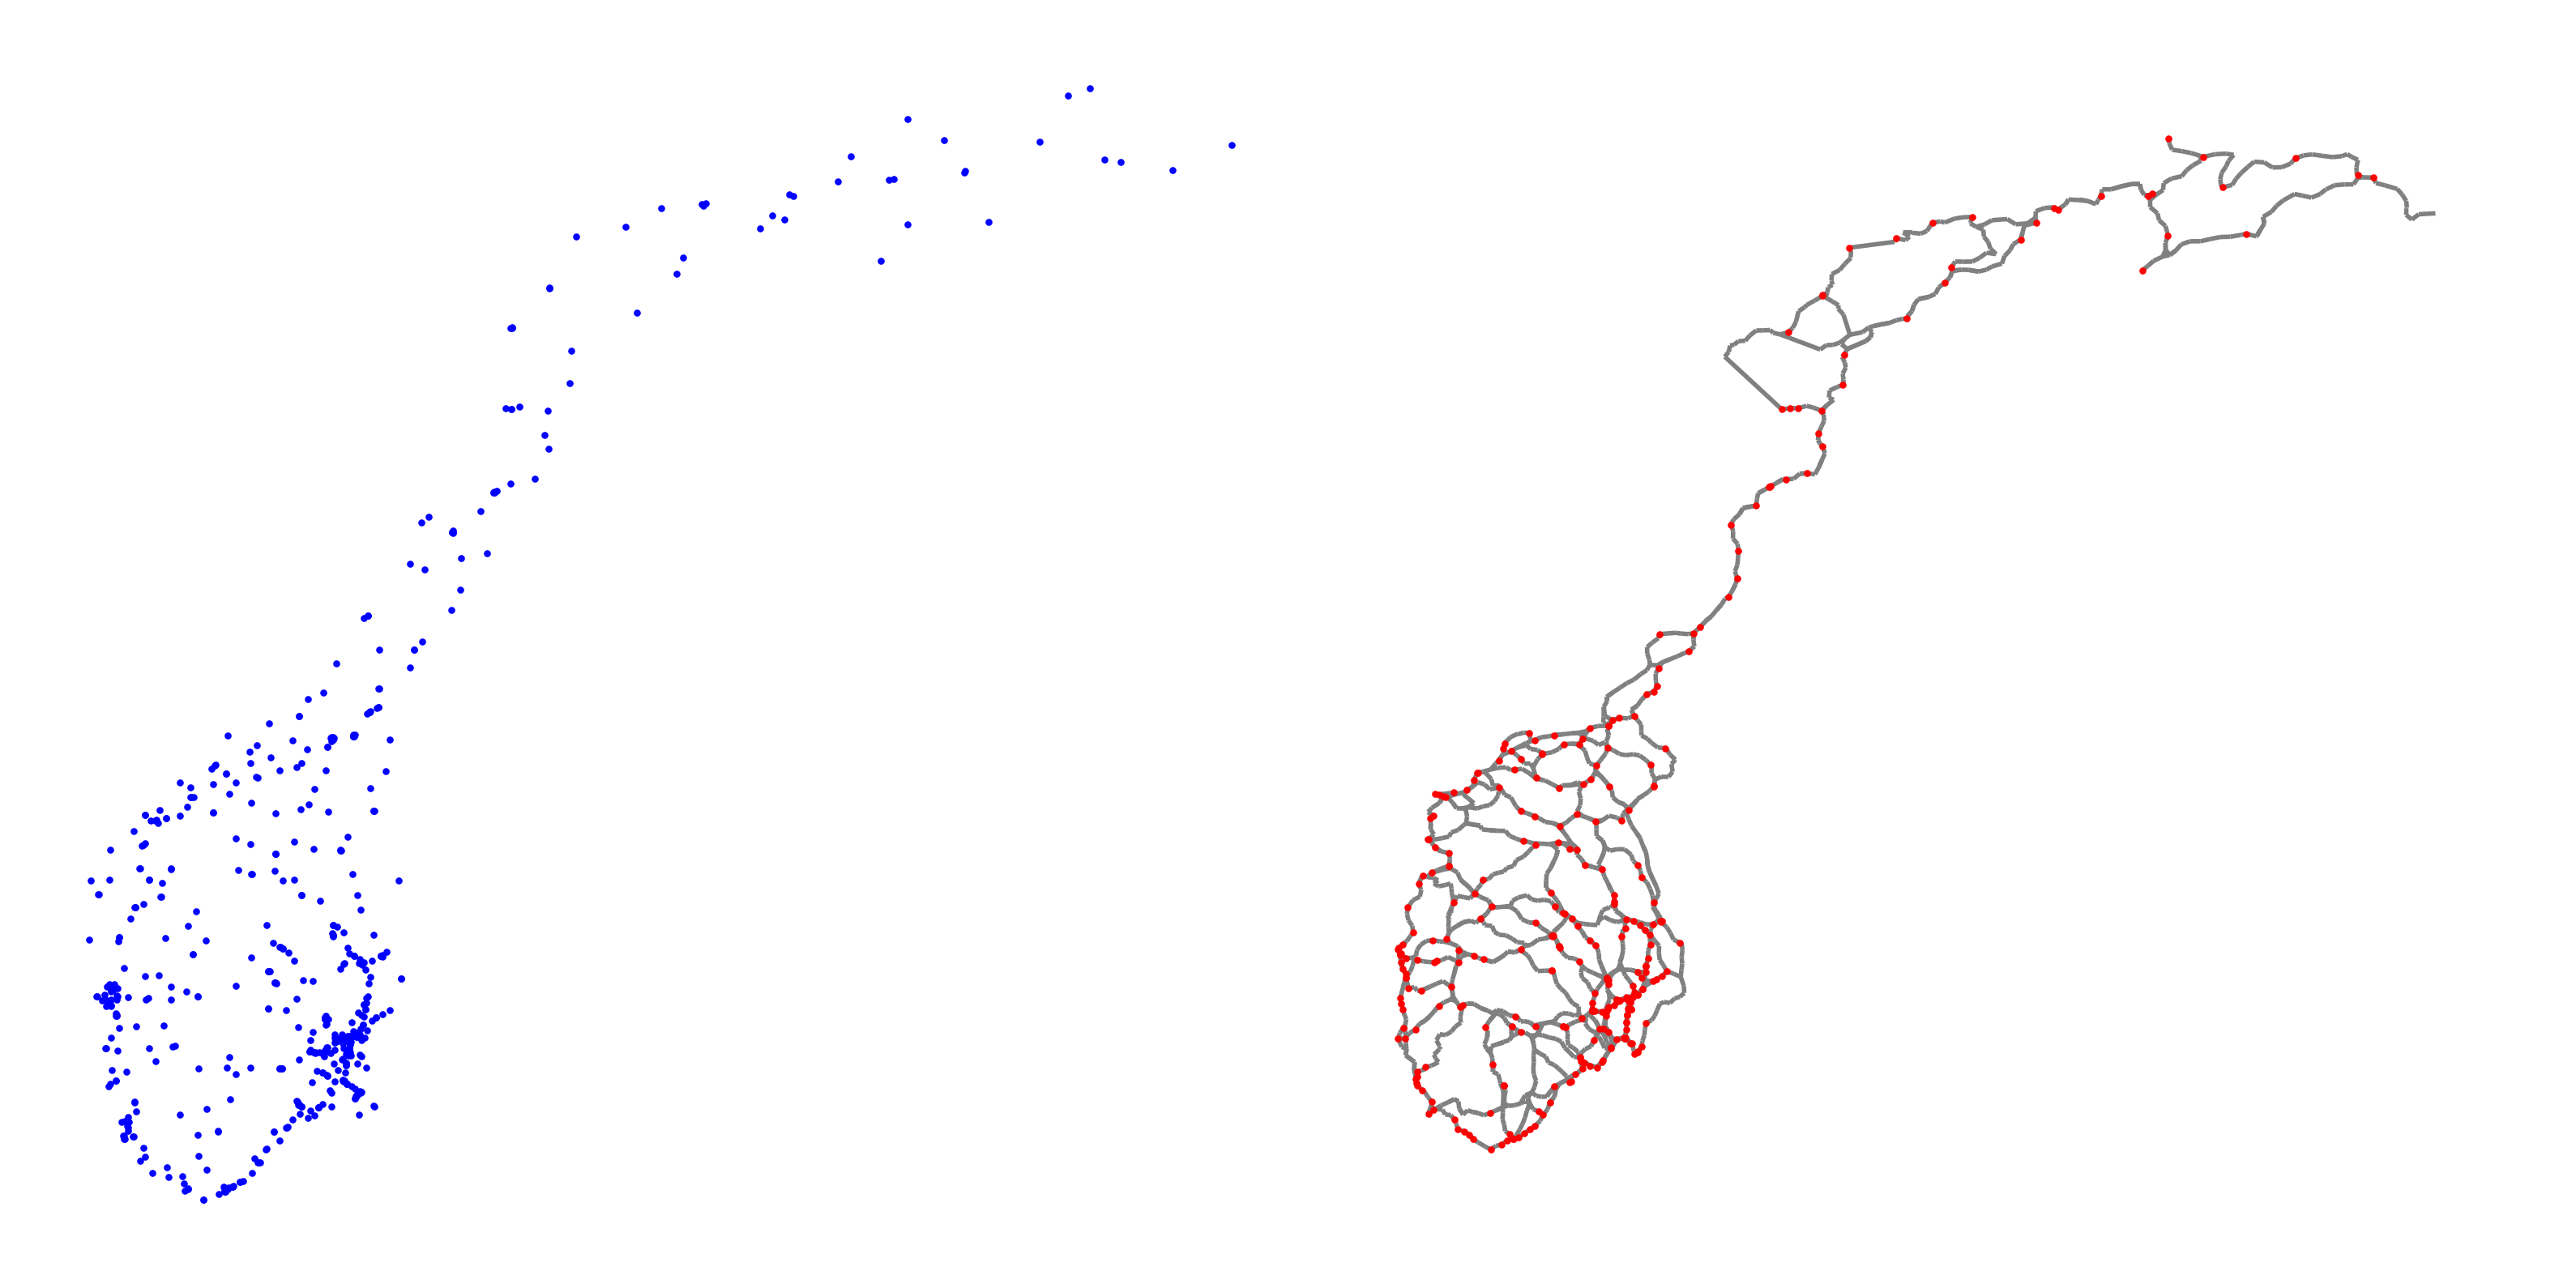

In [19]:
#Visualize All Current CS for actual location CS and simplified network
CSnetwork = nx.Graph()

for i in range(len(CS)):
    CSnetwork.add_node(i)
    CSnetwork.nodes[i]['x']=CS.iloc[i]['Longitude']
    CSnetwork.nodes[i]['y']=CS.iloc[i]['Latitude']

keys = []
vals = []
for i in CSnetwork.nodes:
    x = CSnetwork.nodes[i]['x']
    y = CSnetwork.nodes[i]['y']
    z = (x,y)
    keys.append(i)
    vals.append(z)
zip_iter=zip(keys,vals)
posCS = dict(zip_iter)

keys = []
vals = []
for i in B.nodes:
    if B.nodes[i]['CS']==1 or B.nodes[i]['CSTEST']==1:
        x = B.nodes[i]['x']
        y = B.nodes[i]['y']
        z = (x,y)
        keys.append(i)
        vals.append(z)
zip_iter=zip(keys,vals)
posB2 = dict(zip_iter)

plt.figure(figsize=(10,5), dpi=400)

plt.subplot(1,2,1)
s= nx.draw_networkx_nodes(CSnetwork, posCS, nodelist=list(CSnetwork.nodes), node_size=0.3, node_color="Blue")
plt.axis("off")
plt.subplot(1,2,2)
nx.draw_networkx_edges(B, posAll, edgelist=Alledges, edge_color='grey')
s2 = nx.draw_networkx_nodes(B, posB2, nodelist=simp2, node_size=0.3, node_color="red")

plt.subplots_adjust(wspace=0,hspace=0)
plt.axis("off")
plt.savefig("Data/Figures/CurrentVSsimp.png", dpi=400, bbox_inches="tight", pad_inches=0)

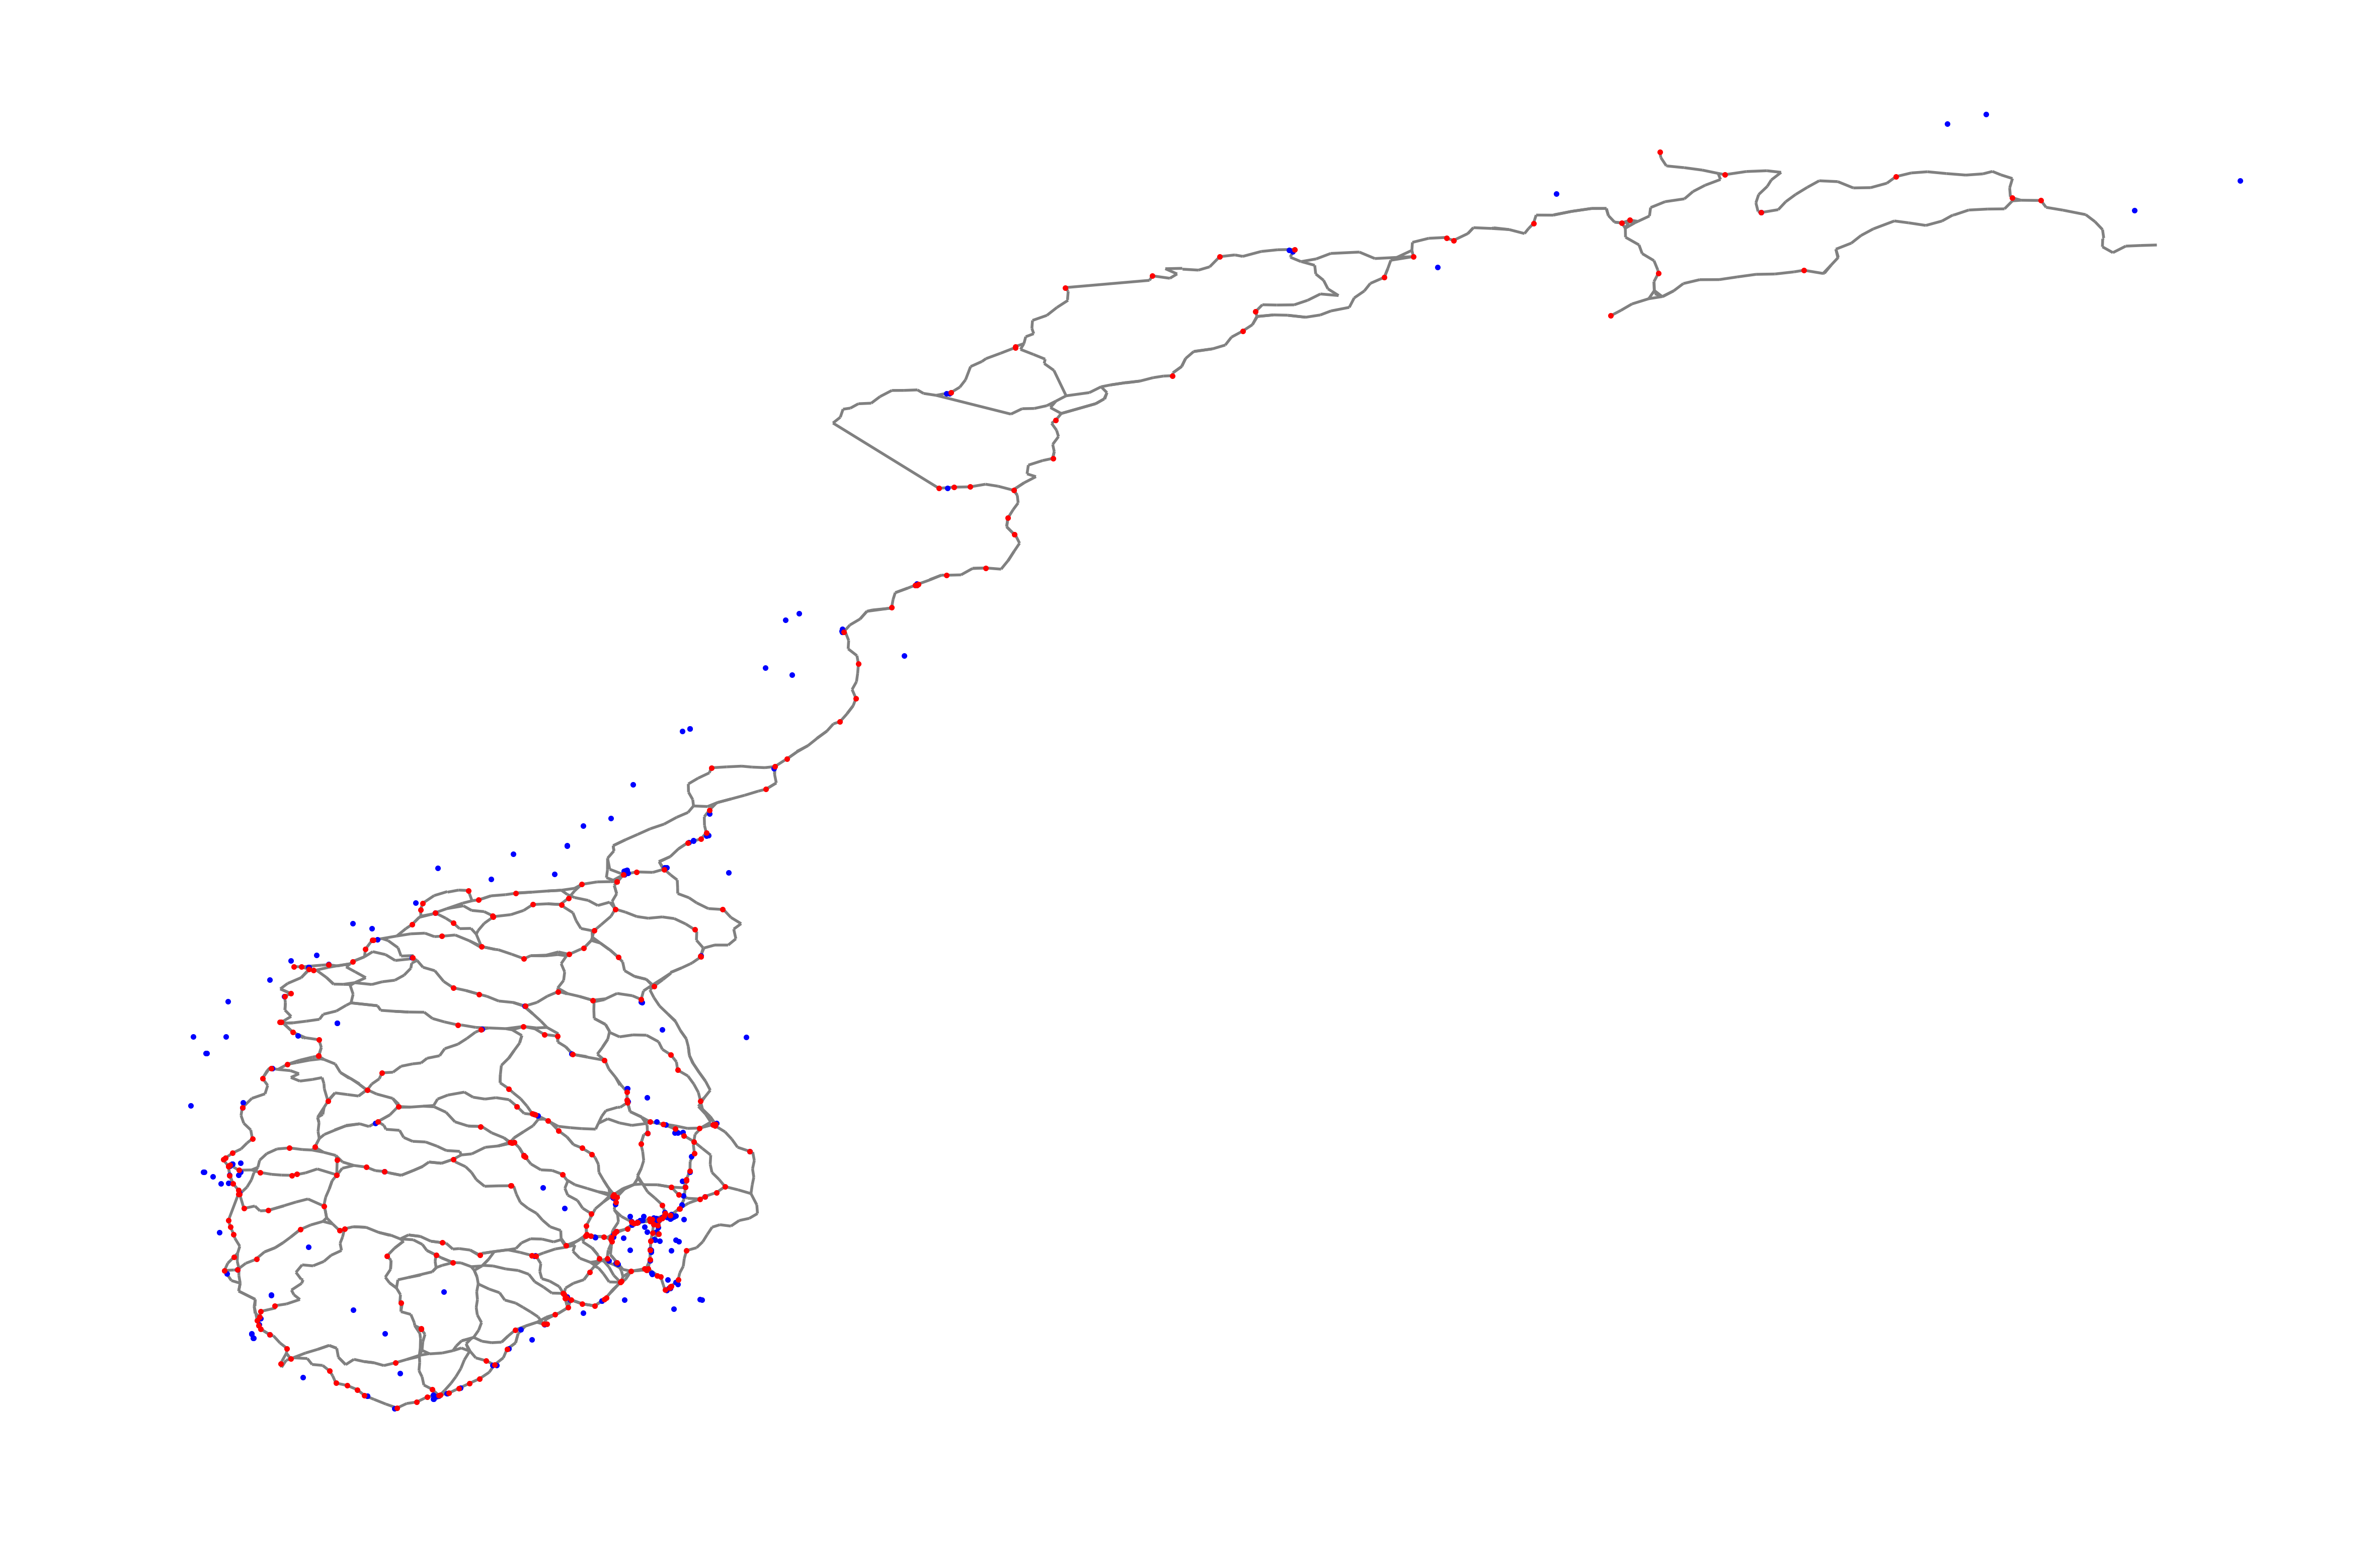

In [20]:
#Also plot CS locations that lie outside current network
CSnetwork = nx.Graph()

for i in range(len(CS_unsimp)):
    CSnetwork.add_node(i)
    CSnetwork.nodes[i]['x']=CS_unsimp.iloc[i]['Longitude']
    CSnetwork.nodes[i]['y']=CS_unsimp.iloc[i]['Latitude']

keys = []
vals = []
for i in CSnetwork.nodes:
    x = CSnetwork.nodes[i]['x']
    y = CSnetwork.nodes[i]['y']
    z = (x,y)
    keys.append(i)
    vals.append(z)
zip_iter=zip(keys,vals)
posCS = dict(zip_iter)


keys = []
vals = []
for i in B.nodes:
    if B.nodes[i]['CS']==1 or B.nodes[i]['CSTEST']==1:
        x = B.nodes[i]['x']
        y = B.nodes[i]['y']
        z = (x,y)
        keys.append(i)
        vals.append(z)
zip_iter=zip(keys,vals)
posB2 = dict(zip_iter)

plt.figure(figsize=(15,10), dpi=400)

s= nx.draw_networkx_nodes(CSnetwork, posCS, nodelist=list(CSnetwork.nodes), node_size=1, node_color="Blue")
nx.draw_networkx_nodes(B, posB2, nodelist=simp2, node_size=1, node_color="red")
nx.draw_networkx_edges(B, posAll, edgelist=Alledges, edge_color='grey')
plt.axis("off")
plt.savefig("Data/Figures/CurrentVSsystemSame.png", dpi = 400, bbox_inches = 'tight')

In [21]:
#Calculate distances between CS in network and actual locations
# CS['node'] = AllCSnodes_unsimp
lengthsdiff = []
counter = 0
for i in B.nodes:
    if B.nodes[i]['CS']==1:
        temp=CS_simplified[CS_simplified['node']==i]
        CSlat = temp.iloc[0]['Latitude']
        CSlon = temp.iloc[0]['Longitude']
        CSlatlon = (CSlat,CSlon)
        
        nodelat = B.nodes[i]['y']
        nodelon = B.nodes[i]['x']
        nodelatlon = (nodelat, nodelon)
        templength = geopy.distance.geodesic(nodelatlon, CSlatlon).m
        if templength < 2000:
              counter +=1
        lengthsdiff.append(templength)
maxval = max(lengthsdiff)
minval = min(lengthsdiff)
meanval = np.mean(lengthsdiff)
medval = np.median(lengthsdiff)
print("Highest deviation:",maxval)
print("Lowest deviation",minval)
print("Mean deviation",meanval)
print("Median deviation", medval)
print("Number of CS > 1000 meters deviation", counter)

Highest deviation: 9934.472766738605
Lowest deviation 0.20422238014646363
Mean deviation 1638.5346630747279
Median deviation 521.2569233455986
Number of CS > 1000 meters deviation 222


In [22]:
def Objectivefunction_b2(FacilitiesList, paths, flows, lengths_dict, G_dict, Totalrange):
    startime = time.time()
    CoveredObjectiveValue = 0
    facilities = tuple(FacilitiesList)
    
    for j in range(len(paths)):
        path = tuple(paths[j])
        NodeInFacilityListExistInPath = False
        if (lengths_dict[path[0],path[-1]]+lengths_dict[path[-1],path[0]]) <=Totalrange/2: # If the round trip length is shorter than half the EV range, add the flow immediately 
            CoveredObjectiveValue += flows[j]
        
        else:
            for node in path:
                if node in facilities:
                    NodeInFacilityListExistInPath = True
                    break
                    
                    
        if NodeInFacilityListExistInPath == True: #Only evaluate if at least one facility is on the path
            
            # Take first from Origin to Destination:
            if path[0] in facilities:
                rem_range = Totalrange
            else:
                rem_range = Totalrange/2
                
            indicator_canRefuel=0
                
            #Start looping through the path going first from origin to the destination:
            revpath = path[::-1][1:]
            fullpath = path+revpath                    
            
            for i in range(len(fullpath)+1):                
                a = fullpath[i]
                b = fullpath[i+1]                                                                                     
                rem_range -= G_dict[(a,b)]

                if rem_range <0:
                    break
                elif b == path[-1] & path[-1] in facilities:
                    indicator_canRefuel+=1
                    break
                elif b == path[0]:
                    indicator_canRefuel+=1
                    break
                elif b in facilities:
                    rem_range = Totalrange                
                
                
            # Now consider from Destination to Origin:
            dest_orig_path = path[::-1]
            fullpath = dest_orig_path + path[1:]
            
            if fullpath[0] in facilities:
                rem_range = Totalrange
            else:
                rem_range = Totalrange/2
            
            for i in range(len(fullpath)+1):            
                a = fullpath[i]
                b = fullpath[i+1]                                                                                     
                rem_range -= G_dict[(a,b)]

                if rem_range <0:
                    break
                elif b == dest_orig_path[-1] & dest_orig_path[-1] in facilities:
                    indicator_canRefuel+=1
                    break
                elif b == dest_orig_path[0]:
                    indicator_canRefuel+=1
                    break
                elif b in facilities:
                    rem_range = Totalrange               
        
            if indicator_canRefuel==2:
                CoveredObjectiveValue += flows[j]
    
                
    # endtime = time.time()
    # finaltime = endtime-startime
    # print('B2: '+str(finaltime))
    return CoveredObjectiveValue

In [ ]:
value170 = Objectivefunction_b2(simp2, paths, flows, lengths_dict, B_dict,170000)
value325 = Objectivefunction_b2(simp2, paths, flows, lengths_dict, B_dict,325000)
value585 = Objectivefunction_b2(simp2, paths, flows, lengths_dict, B_dict,585000)
print("Flow covered Current Situation 170km range:",round(value170,3))
print("Flow covered Current Situation 325km range:",round(value325,3))
print("Flow covered Current Situation 585km range:",round(value585,3))

Flow covered Current Situation 170km range: 0.879
Flow covered Current Situation 325km range: 1.0
Flow covered Current Situation 585km range: 1.0
